# Deep Learning in Finance

Deep Learning, a start of the art methodology used to deal with huge amount of data and can handle both supervised and unsupervised data. 
The amazing part of this Deep Learning is that it uses Neural Netwroks - an interconnected web of nodes and the edges that join them together. It has a potential to learn the features and reduce errors through Forward propogation and Backward propogation. The errors are minimised through Gradient Descent techniques. 

##### Applications of Deep Learning

Sentiment Analysis <br>
Named Entity Recognition <br>
Image Recognition <br>
Object Recognition <br>
Speech Recognition <br>
Time Series Analysis and many more...<br>

##### Deep Learning in Finance

Stock Market Prediction <br>
Financial Security <br>
Automation Process <br>
Analysing Trading Strategies <br>
Loan Application Evaluation <br>
Credit Card Customer Research and many more... <br>
<br>
Companies like CRISIL, JP Morgan Chase, BNY Mello and others are using Deep Learning Frameworks in their financial fields.<br>
###### Here we will be discussing about Stock Market Trend Prediction.

### Stock Market  Trend Prediction 
Here, we try to predict the direction of market(uptrend or downtrend) using a set of features, thus we can consider it as a Binary Classification problem i.e <br>
0 implies a Down trend in the market <br>
1 implies an Up trend in the market
<br>
<br>
We will use LSTM(a Recurrent Neural Network architecture) to predict the Stock Market trend

### 1. Getting the system ready and loading the data

We are using Yahoo! Finance data to get the stock price of a market.<br>
Installing Yahoo! Finance python module.

In [93]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [94]:
# Importing the required packages.

# pip install pandas
# pip install numpy
import pandas as pd # A python library used for data manipulation.
import numpy as np  # A python library used for arithmetic operations on arrays.


# Using Yahoo!Finance to get the market data.
import yfinance as yf 

# Scikit-learn is used for machine learning and statistical modelling of the data.
# pip install -U scikit-learn
# Used to transform features by scaling each feature to a given range.
from sklearn.preprocessing import MinMaxScaler 

# Machine Learning libraries to create plots and data visualizations.
# Matplotlib is a low-level library with a Matlab like interface, 
# good for creating basic graphs like Line Chart, Bar Chart, Histogram, etc.
import matplotlib.pyplot as plt 
# Seaborn - A python visualisation library based on Matplotlib.
# Visuals that need around 20 lines of code using Matplotlib can be created
# with seaborn by reducing the code to 5-fold.
import seaborn as sns

# Import scikit-learn metrics module to calculate the model accuracy.
from sklearn import metrics 

# Ignoring all warnings.
import warnings
warnings.filterwarnings('ignore') 

In [95]:
# Loading the data.
# We are Using Apple's stock price data from 1st Jan, 2018 to 26th July, 2020.
# "AAPL" is the stock symbol for Apple Computer, Inc.
dataset = yf.download("AAPL", start="2018-01-01", end="2020-07-26")

[*********************100%***********************]  1 of 1 completed


### 2. Dataset Content

In [96]:
# The stock price dataframe.
# Previewing our data using the code below.
# DataFrame.head() method is used to display the first 5 rows from the data.
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,170.160004,172.300003,169.259995,172.259995,166.353714,25555900
2018-01-03,172.529999,174.550003,171.960007,172.229996,166.324722,29517900
2018-01-04,172.539993,173.470001,172.080002,173.029999,167.097290,22434600
2018-01-05,173.440002,175.369995,173.050003,175.000000,168.999741,23660000
2018-01-08,174.350006,175.610001,173.929993,174.350006,168.372040,20567800


##### Understanding the Columns
Open &emsp;   - Opening value of stock price <br>
High &emsp;  - Highest value of the stock price in that day <br>
Low  &emsp;   - Lowest value of the stock price in that day <br>
Close &emsp;  - Closing value of the stock price in that day <br>
Adj Close - Adjusted Closing values of the stock price after closing. <br>
&emsp; &emsp; &emsp; &emsp; &ensp; Generally the stock value after the dividends or stock-splits or stock offerings are posted.<br>
Volume  - Total number of shares traded in that day.

Adjusted closing price amends a stock's closing price to accurately reflect that stock's value after accounting for any corporate actions. <br>
The closing price is the 'raw' price which is just the cash value of the last transacted price before the market closes. <br>
Adjusted closing price factors in corporate actions such as stock splits, dividends / distributions and rights offerings.<br>Investopedia

In [97]:
# Previewing our data.
# DataFrame.tail() method is used to display the last 5 rows from the data.
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-20,385.670013,394.000000,384.250000,393.429993,393.429993,22579500
2020-07-21,396.690002,397.000000,386.970001,388.000000,388.000000,25911500
2020-07-22,386.769989,391.899994,386.410004,389.089996,389.089996,22250400
2020-07-23,387.989990,388.309998,368.040009,371.380005,371.380005,49251100
2020-07-24,363.950012,371.880005,356.579987,370.459991,370.459991,46359700


We can see that the last entry is on 24th July, 2020. <br>
The stock markets are closed on Saturdays' and Sundays' along with some public holidays.<br>
25th and 26th of July are Saturday and Sunday respectively.

In [98]:
# Showing information about a DataFrame including the index dtype and columns, 
# non-null values and memory usage.
dataset.info()
# float64 - repreents a floating point number.
# int64 - represent an integer number.
# The Open, High, Low, Close and Adj Close are floating point numbers. 
# Volume isn't a floating point number, 
#  because fractional shares aren't available from the stock market.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 645 entries, 2018-01-02 to 2020-07-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       645 non-null    float64
 1   High       645 non-null    float64
 2   Low        645 non-null    float64
 3   Close      645 non-null    float64
 4   Adj Close  645 non-null    float64
 5   Volume     645 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 35.3 KB


In [99]:
#The describe() method provides the descriptive statistics of the dataset.
dataset.describe()
# 'count' tells the number of non-NA/null observations.
# 'max' shows the maximum of the values in the object.
# 'min' shows the minimum of the values in the object.
# 'mean' shows the Mean of the values.
# 'std' shows the Standard deviation of the observations.
# Standard deviation is a measure of amount of variation of a set of values,
# it tells how the spread out the data is.
# A low standard deviation means that most of the numbers are close to the average (mean)
# A high standard deviation means that the numbers are more spread out
# Percentile- a measure used in statistics indicating the value
# below which a given percentage of observations in a group of observations falls.
# Percentile provides where the value actually lies in the data.
# 25% shows that 25 percent of the data lies below that number.
# 50% shows that 50 percent of the data lies below that number.
# 75% shows that 75 percent of the data lies below that number.

# Consider Open.
# prices from previous close to till 180.199 consitutes to 25% of the data
# prices till 204.399 constitutes to 50% of the data and,
# prices till 257.329 constitutes to 75% of the data.
# The mean value 223.21 lies below 75% of the data.
# The min value 143.979 lies below 25% of the data.
# The max value is about 396.690 lies above 75% of the data.

,Open,High,Low,Close,Adj Close,Volume
count,645.000000,645.000000,645.000000,645.000000,645.000000,6.450000e+02
mean,223.210775,225.787721,220.977008,223.513550,220.546404,3.338395e+07
std,56.644627,57.544756,55.942842,56.876893,58.226482,1.512016e+07
min,143.979996,145.720001,142.000000,142.190002,139.376251,1.136200e+07
25%,180.199997,182.139999,178.160004,179.660004,176.204834,2.304670e+07
50%,204.399994,206.500000,203.320007,204.610001,201.871216,2.959680e+07
75%,257.329987,262.470001,256.290009,259.429993,258.136963,3.928130e+07
max,396.690002,399.820007,386.970001,393.429993,393.429993,1.067212e+08


### 3. Preprocessing the Data

Data preprocessing plays a crucial role while building a model. The data may not be in the right format or the initial data may not fit the model. <br>
Sometimes we need to modify the data as per our requirements.

We discussed about the term **Adjusted Close** previously.<br>
This Adjusted Close makes a profound impact on the historical prices(here Open, High and Low prices). <br>To compensate this, we need to adjust the historical prices by a factor. <br>
<br>
The amount of the dividend is subtracted from the prior day’s close price; that result is then divided by the prior day’s close price. Historical prices are subsequently multiplied by this factor. <br>
<br>
This factor is termed as *Adjustment Factor*. <br>
**Adjustment Factor = (Close - Dividend)/Close** <br>
Which is nothing but Adjusted Close Price divided by Close Price of the market
<br>

In [100]:
# Calculating Adjustment Factor
dataset['AdjustmentFactor'] = dataset['Adj Close']/dataset['Close']

# Adjusting Open, High and Low values.
dataset['Adj Open'] = dataset['Open'] * dataset['AdjustmentFactor']
dataset['Adj High'] = dataset['High'] * dataset['AdjustmentFactor']
dataset['Adj Low'] = dataset['Low'] * dataset['AdjustmentFactor']

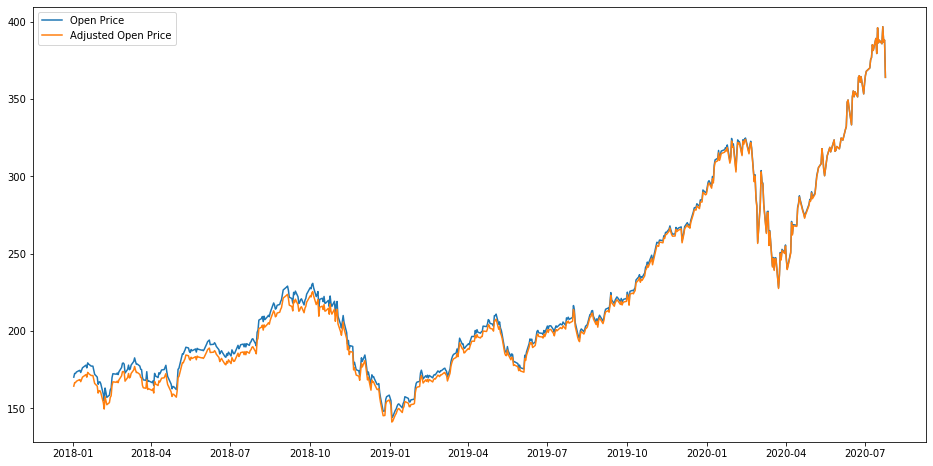

In [101]:
# Exploring the Open Price and Adjusted Open Price.
# We will look how the Open price and Adjusted Open Price differ by plotting the graph.
# Using Matplotlib library to plot the graph.
# figure() method is used to create a figure object.
# It is explicitly used to modify the size of a figure or add multiple axes in a figure.
# The parameter figsize takes float values, which denotes the Width and Height in inches.
# plot() method is used to plot data on x axis and y axis.
# Here dataset.index i.e Date is taken on x axis and dataset['Open'] is taken on y axis.
# We defined two plots one for 'Open' and one for 'Adj Open', to plot in a single figure.
# The legend() method is used to describe the elements of the graph.
# The show() method is used to display a figure.
plt.figure(figsize=(16,8))
plt.plot(dataset.index, dataset['Open'], label='Open Price')
plt.plot(dataset.index, dataset['Adj Open'], label='Adjusted Open Price')
plt.legend()
plt.show()

### 4. Feature Extraction

Feature Extraction is used to reduce the dimensionality of data and increase the accuracy of the model. <br><br>

We will be using the following features for classification
    1. Mean value of Adjusted Open, High and Low. <br>
    2. Adjusted Close value. <br>
    3. Returns of the day before.

We can calculate the mean value of adjusted 'Open', 'High' and 'Low' prices and use this mean as an input to the model.<br> 
So, why the mean? In general the tendency of a variable i.e stock price to converge on an average value over time is called Mean Reversion. This is used to predict upward or downward trend of a market. <br>

Returns of the day - The daily returns measures the value change in a stock's price as a percentage of the previous day's closing price. A positive return means the stock has grown in value, while a negative return means it has lost value.

In [102]:
# 1. Mean of Adjusted Open, High and Low.
OHL_mean = dataset[['Adj Open','Adj High','Adj Low']].mean(axis = 1)

In [103]:
# 2. Adjusted Close.
close_value = dataset[["Adj Close"]]

In [104]:
# 3. Returns of the day before.
# Calculated using the Percentage Change method,
# i.e [(Present value - Previous value)/Present Value] * 100.
returns = dataset[['Adj Close']].pct_change()

In [105]:
# Concatenating the above extracted features using pandas.concat() method.
# The parameter axis=1 tells to concatenate along columns.
new_data = pd.concat([OHL_mean, close_value, returns], axis=1)
# Setting the column names.
new_data.columns = ['OHL', 'Adj Close', 'Returns']

In [106]:
# Type of the data.
type(new_data)
# 'new_data' is a dataframe object.

pandas.core.frame.DataFrame

In [107]:
# Previewing the newly created data using the code below.
new_data.head()

,OHL,Adj Close,Returns
Date,,,
2018-01-02,164.724884,166.353714,NaN
2018-01-03,167.081204,166.324722,-0.000174
2018-01-04,166.775386,167.097290,0.004645
2018-01-05,167.988961,168.999741,0.011385
2018-01-08,168.642433,168.372040,-0.003714


In [108]:
# Descriptive statistics of the 'new_data' dataset.
new_data.describe()

,OHL,Adj Close,Returns
count,645.000000,645.000000,644.000000
mean,220.359080,220.546404,0.001473
std,58.038303,58.226482,0.021362
min,141.052409,139.376251,-0.128647
25%,176.259799,176.204834,-0.007667
50%,202.117826,201.871216,0.001649
75%,257.283544,258.136963,0.011424
max,393.553335,393.429993,0.119808


In [109]:
# Converting 'new_data' dataframe into a numpy array for easier data manipulation.
new_data = new_data.to_numpy()
# To find out the type of data.
type(new_data)
# numpy.ndarray represents a numpy array of n dimensions.

numpy.ndarray

In [110]:
# Shape of 'new_data'.
new_data.shape
# (645, 3) represents tuple of 3 dimensional array of size 645.

(645, 3)

In [111]:
# The above data doesn't have a target variable.
# We need a target variable to train the model.
# Since binary classification consists of 0s and 1s as target variables...
# We must create a traget varible with 0s and 1s based on the Returns.
# Numpy.sign() method is used to return an element-wise indication of the sign of a number.  
# -1 if Returns <0,
# 0 if Returns = 0,
# 1 if Returns >= 1.
# new_data[,:2] - Selecting the third column i.e 'Returns'.
# We are adding 1 to convert negative 1s to 0s and dividing by 2.
target_var = (np.sign(new_data[:,2])+1)/2

In [112]:
# Shape of the target variables.
target_var.shape
# (645,) represents a tuple of 645 entries | A one dimensional array of size 645.

(645,)

In [113]:
# To find the type of target_var.
type(target_var)

numpy.ndarray

### 5. Feature Scaling

In [114]:
# If you observe the newly created data 'new_data'.
# The OHL values are in between 141 to 394.
# The Adjusted Close values are in between 139 to 394.
# The Returns values are in betwen -1.3 to 1.2.
# This shows the data is not distributed normally.
# When the model is training it is biased more towards OHL values...
# Becaue of the higher range in OHL value the model thinks it as an important feature.
# The model neglects or give less importance to 'Adj Close' and 'Returns' features.
# To overcome this problem we need to scale the data into a specific range.
# We are using MinMaxScaler() method from sklear.preprocessing library to scale the data
# Defining the min-max scalar for scaling the features into a range of 0 to 1.
scaler = MinMaxScaler(feature_range=(0, 1))

# Scaling the features.
new_data = scaler.fit_transform(new_data)
# Look the target variable isn't scaled. We focused on the independent feautures here.
# The target variable consist either a 1 or a 0.

In [115]:
# Concatenating the features or independent variables and target variables.
# Since both 'new_data' and 'target_var' are numpy arrays we use numpy.concatenate() method.
# 'axis=1' parameter represents to concatenate along the columns.
data = np.concatenate([new_data, target_var.reshape(-1, 1)], axis=1)

The numpy.reshape method is used to change the shape of a numpy array without changing its data. <br> <br>
The reshape() function when called on an array takes one argument which is a tuple defining the new shape of the array. We cannot pass in any tuple of numbers; the reshape must evenly reorganize the data in the array. <br> <br>
The shape of target_var is (645,) i.e 645 entries of 1D array.<br>
np.reshape(-1,1) tells to reshape the array into 2D array of size 645. <br>
i.e reshape with (-1, 1) represents that we have provided column as 1 but rows as unknown.


In [116]:
# Shape of the data.
data.shape

(645, 4)

In [117]:
# Remove all rows with either feature or label null.
# np.isnan() test element-wise for NaN and return result as a boolean array. 
# any(axis=1) method is used to check for NaN along a column.
data = data[~np.isnan(data).any(axis=1)] # selecting the data free of NaN values.

data.shape

(644, 4)

This shows that a single NaN value is present in the dataset and it is removed.

In [118]:
# Splitting the data into train and test subsets.
# train subset is used for training the model.
# test subset is used for testing the model.
# 75% of the data is used to train.
# 25% of the data is will be tested for model accuracy.
# data.shape[0] provides the number of entries in the data. Here the value is 644.
# int() method is used to change the data type of an object to an integer type.
train_data_length = int(data.shape[0]*0.75)

# Splitting 75% of data into train and remainning 25% into test subsets.
# data[0:train_data_length] selects the first 75% rows of the data,
# data[train_data_length:] selects the remaining 25% rows of the data.
train_data, test_data = data[0:train_data_length], data[train_data_length:]

# xtrain is the training group with independent features i.e 'OHL', 'Adj Close' & 'Returns'.
# ytrain is the target variables for training group.
# xtest is the testing group with independent features i.e 'OHL', 'Adj Close' & 'Returns'.
# ytest is the target variables for testing group.
xtrain = train_data[:,:3]
ytrain = train_data[:,3]
xtest = test_data[:,:3]
ytest = test_data[:,3]

In [119]:
# shape of xtrain.
xtrain.shape

(483, 3)

In [120]:
# shape of xtest.
xtest.shape

(161, 3)

### 6. Model Building

We are using LSTM to predict the Stock Market trend. <br> <br>
**LSTM - Long Short-Term Memory cell** <br>
LSTM is a Recurrent Neural Network architecture generally used when dealing with Sequence Prediction problems or Time Series problems. <br><br>
LSTM has a property of selectively remembering patterns for ling durations of time. This helps to deal with a wide range of problems; from predicting sales to finding patterns in stock markets, from recognizing your speech to translating languages and predicting your next word on your mobile's keyboard.
- RNN often face a problem with Gradient Descent. If we backpropogate more than 9 or 10 timesteps, we can encounter with Vanishing Gradient.
- To address this issue LSTMs are being used.

In [121]:
# Importing libraries to create a LSTM model.
# keras is a neural network library built in Python.
# keras.model is a data structure representing a neural network model.
# keras.model contains two types of models, Sequential model and Functional API.
# Sequential model is a linear stack of layers.
# Functional API model has branched layers.
# keras.layers is used to build the layers of Neural Network.
# The layers include Dense, Activation and Dropout.
# Dense layers consists of neurons or nodes which perfoms an operation on inputs and produces an output.
# The operation perfomed by Dense layer: output = activation(dot(input, weights) + bias).
# Activation: Applies an activation function to an output.
# Dropout: randomly set a fraction of input units to 0 at each training update to avoid overfitting.
# LSTM: A recurrent layer.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

# Number of features.
# Our data is having 3 independent features: 'OHL', 'Adj Close' & 'Returns'.
features = 3
 
# Creating a Sequential model.
classifier = Sequential()

# Add LSTM later with 50 units and input size (1,3).
# units - the number of nodes in the hidden layers within the LSTM cell.
# return_sequences - when set to true it return the outputs from the LSTM cell.
# When training the output at each time step can be used to compare with very next value to find the errors.
# input_shape - LSTM requires a 3 dimensional array as an input.
# input_shape - (batch_size, time_steps, features).
# batch_size: number of samples.
# time_steps: number of time dependent steps in a single data point.
# features: number of independent variables.

# First layer is an LSTM layer with 50 memory units and it returns sequences. 
# This is done to ensure that the next LSTM layer receives sequences and 
# not just randomly scattered data.
classifier.add(LSTM(units = 50, return_sequences = True, input_shape = (1, features)))

# Add dropout for regularisation. 
# A dropout layer is applied after each LSTM layer to avoid overfitting of the model. 
classifier.add(Dropout(0.2))

# Add another LSTM unit.
classifier.add(LSTM(units = 50, return_sequences = True))
# Add dropout for regularisation.
classifier.add(Dropout(0.2))

# Add another LSTM unit.
classifier.add(LSTM(units = 50, return_sequences = True))
# Add dropout for regularisation.
classifier.add(Dropout(0.2))

# Add another LSTM unit.
classifier.add(LSTM(units = 50))
# Add dropout for regularisation.
classifier.add(Dropout(0.2))

# Add fully connected layer with one output as a prediction.
classifier.add(Dense(units = 1))
 
# The model is created and configuring the model with losses and metrics.
# Compile the model - set loss function, optimisation algorithm and evaluation metric.
# loss function: a method to evaluate how well the model is performing,
# 'mean_squared_error': measure the average of the squares of errors,
# optimisation algoritm: used to reduce the loss value by optimising the model,
# 'adam' optimizer: an adaptive learning rate optimization algorithm for Deep Learning models,
# metrics: used to judge the model performance. Similar to loss function,
# the metric results are not used when training the model unlike loss function,
# 'accuracy' used to compute the accuracy rate between predicted values and true values.
# Accuracy = (number of correctly classified points/ number of total points).
classifier.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

Since LSTM layer expects the input to be in the form (batch_size, time steps, features), we need to reshape the input data. <br>
xtrain.shape = (483,3) <br>
xtest.shape = (161, 3) <br>

To reshape a 2D numpy array to 3D numpy array we can use the following notation:<br>
np.reshape(data, (a,b,c)) <br>
To match the requirements of the LSTM model we will use the following notation: <br>
np.reshape(data, (data.shape[0], 1, data.shape[1])

In [122]:
# Reshaping the data so as to fit in the model.
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))

In [123]:
# xtrain shape.
xtrain.shape

(483, 1, 3)

In [124]:
# xtest shape.
xtest.shape

(161, 1, 3)

##### Fitting the model

In [128]:
# Fitting the model with 25 epochs, with a batch size of 1.
# The model is fitted with train features and train target varaibles.
# epochs: an epoch refers to one cycle through the full training dataset.
# batch_size: number of samples to be processed at a time.
# validation_split: used to split the dataset to find the way the model is training.
# During training, (xtrain, ytrain) data is used to adjust trainable parameters of the model. 
# However, we don't know whether model is overfit or under fit, 
# whether model is going to do well when new data is provided. Thus validation is used to address this problem.
# The fitted model is saved into 'history' variable.
history = classifier.fit(xtrain, ytrain, epochs=25, batch_size=1,  validation_split=0.25)

Train on 362 samples, validate on 121 samples
Epoch 1/25
362/362 [==============================] - 4s 12ms/step - loss: 0.0857 - accuracy: 0.8757 - val_loss: 0.0582 - val_accuracy: 0.9091
Epoch 2/25
362/362 [==============================] - 5s 13ms/step - loss: 0.0704 - accuracy: 0.8950 - val_loss: 0.1338 - val_accuracy: 0.7934
Epoch 3/25
362/362 [==============================] - 5s 15ms/step - loss: 0.0689 - accuracy: 0.9061 - val_loss: 0.0435 - val_accuracy: 0.9587
Epoch 4/25
362/362 [==============================] - 5s 13ms/step - loss: 0.0518 - accuracy: 0.9309 - val_loss: 0.0304 - val_accuracy: 0.9669
Epoch 5/25
362/362 [==============================] - 5s 13ms/step - loss: 0.0528 - accuracy: 0.9392 - val_loss: 0.1736 - val_accuracy: 0.7686
Epoch 6/25
362/362 [==============================] - 5s 14ms/step - loss: 0.0559 - accuracy: 0.9282 - val_loss: 0.0634 - val_accuracy: 0.8926
Epoch 7/25
362/362 [==============================] - 5s 15ms/step - loss: 0.0529 - accuracy: 0.

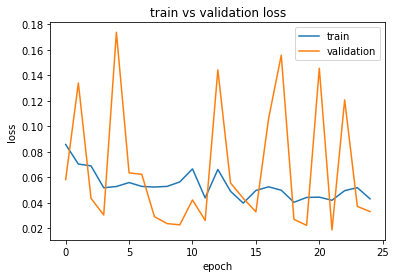

In [129]:
# 'history' attribute is a dictionary recording training loss values and metrics values at successive epochs, 
# as well as validation loss values and validation metrics values.
# Plotting the loss values of training set and validation set.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# Setting the title of the graph.
plt.title('train vs validation loss')
# Labelling the axeas respectively.
plt.ylabel('loss')
plt.xlabel('epoch')
# Describing the elements and setting them at upper right location on the plot.
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

While the epochs are increasing, Train and Validation losses are decreasing.<br>
The spikes observed in the validation loss, is due to the consequence of Mini-Batch Gradient Descent(here the batch size is 1) in Adam optimizer. 

In [131]:
# Get test and train set predictions.
# Predicting the train and test data by using the above model.
train_prediction = classifier.predict(xtrain)
test_prediction = classifier.predict(xtest)
# Comparing the prediction accuracy of Train and Test helps to identify whether,
# the model is either underfitting or overfitting.
# Underfitting: Error due to bias i.e model doesn't do well on training set,
# i.e the model did not extract the important features from train data.
# Overfitting: Error due to variance i.e the model does well in training set but, not on test data,
# i.e the model not only selected the important patterns, it selecte the non-prominent patterns too.

### 7. Metrics

Our goal is to accurately predict the trend of 'Apple Computer, Inc.' Stock Market.<br>
We need to evaluate how well our model is performing i.e we need to know how much we can trust this model for predicting an unknown sample. <br><br>
To calculate the model accuracy we will be using 'Confusion Matrix'. <br>
Confusion Matrix: A table used to describe the performance of a classification model on a set of test data for which the true values are known. <br>
Basic terms used in Confusion Matrix:
1. True Positives(TP): These are the cases where the model correctly predicted positive class.
2. True Negatives(TN): These are the cases where the model correctly predicted negative class.
3. False Positives(FP): These are the cases where the model incorrectly predicted negative class as positive class.
4. False Negative(FN): These are the cases where the model incorrectly predicted positive class as negative class.

Accuracy: Overall performance of the model = (TP+TN)/(TP+FP+TN+FN)

In [133]:
# Since we need a binary value either 0 or 1 we will convert the obtained continuous values from prediction.
# 1 if predicted value >= 0.5,
# 0 if predicted value < 0.5.
# np.where(condition,a,b). a and b are the values defined based on the condition.
# Here when the condition is true the value is 1, else it is 0.
test = np.where(test_prediction>0.5, 1, 0) 

# Get the confusion matrix for binary classification.

# Reshaping the predicted values.
test = test.reshape(161,)

# Confusion Matrix.
# Converting the datatype of testtarget values to integer value.
cf_matrix = metrics.confusion_matrix(ytest.astype(int),test)
cf_matrix

array([[70,  0],
       [ 7, 84]])

True Positives(predicted 1s/actual 1s) = 84 <br>
True Negatives(predicted 0s/actual 0s) = 70 <br>
False Positives(predicted 1s/actual 0s) = 0 <br>
False Negatives(predicted 0s/actual 1s) = 7 <br>

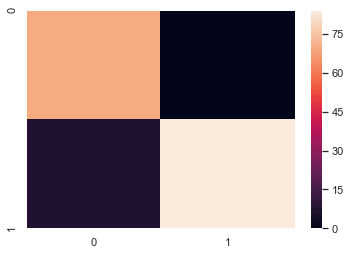

In [138]:
# Plotting a heatmap to understand how the predicted and actual values are distributed.
sns.set()
sns.heatmap(cf_matrix)

In [140]:
# Mean Squared Error gives the average of the squares of the errors.
# We are squaring the errors to avoid cancelling effect i.e sometimes postivive errors and 
# negative errors get cancelled.
# A lower mean squared error represents that model has a higher accuracy.
metrics.mean_squared_error(ytest.astype('int'),test)

0.043478260869565216

In [141]:
# F1 Score is an important metric in classification problems.
# F1 Score is the harmonic mean of Precision and Recall.
# F1 Score = 2*((Precision*Recall)/(Precision+Recall)).
# Precision: (True Positive/(True Positive+False Positive)),
# i.e Precision gives the proportion of predictede actual positives among predicted positives.
# Recall: (True Positive/(True Positive + False Negative)),
# i.e Recall gives the proportion of predicted actual positives among total actual positives.
# A higher F1 Score value indicates that the model is accurate.
metrics.f1_score(ytest.astype('int'), test)

0.9600000000000001

Eventhough we build an accurate model, the predictions made are totally different from the real prices. <br>
In real-world the Stock Market prices depend on the numerous factors like Supply and Demand in the market, Government Policies, News and many more. <br>
This model doesn't consider any sentiment or news or any other factors other than stock data. In real-world this model fails to meet the right prediction.